In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Get dataframe
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/CSC413FinalProject/liar_dataset/train.tsv', delimiter='\t', header=None)
# Optionally, add column names if the file doesn't include headers
df.columns = ["ID", "Label", "Statement", "Subject", "Speaker", "Speaker_Job", "Speaker_State", "Party", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]

In [3]:
# Get Training labels
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

labels = list(df['Label'])

# Example list
categories = np.array(labels).reshape(-1, 1)

# Create the encoder and fit it
encoder = OneHotEncoder(sparse=False)
labels = encoder.fit_transform(categories)

print(labels.shape)

(10240, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
# Get validation Labels
df_val = pd.read_csv('/content/drive/MyDrive/CSC413FinalProject/liar_dataset/valid.tsv', delimiter='\t', header=None)
# Optionally, add column names if the file doesn't include headers
df_val.columns = ["ID", "Label", "Statement", "Subject", "Speaker", "Speaker_Job", "Speaker_State", "Party", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]

val_labels = list(df_val['Label'])

# Example list
categories = np.array(val_labels).reshape(-1, 1)

# Create the encoder and fit it
encoder = OneHotEncoder(sparse=False)
val_labels = encoder.fit_transform(categories)

print(val_labels.shape)

(1284, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
# Get Training embeddings
import torch
train_input = torch.load('/content/drive/MyDrive/CSC413FinalProject/RNN_embeddings.pt').to('cuda:0')

In [6]:
# Get Validation embeddings
val_input = torch.load('/content/drive/MyDrive/CSC413FinalProject/RNN_embeddings_val.pt').to('cuda:0')

In [ ]:
#concatenate val and train
#full_inputs = torch.cat((train_input, val_input), dim=0)
#full_labels = torch.cat((torch.Tensor(labels), torch.Tensor(val_labels)), dim=0)
full_inputs = train_input
full_labels = torch.tensor(labels)
#Perform KFold Cross Validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Prepare data loader
from torch.utils.data import DataLoader, TensorDataset
print(full_inputs.shape)
print(full_labels.shape)
dataset = TensorDataset(full_inputs, full_labels)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

torch.Size([10240, 512, 768])
torch.Size([10240, 6])


In [ ]:
#parameters for the RNN model
input_size = last_hidden_states.shape[-1]  # Size of BERT hidden states
hidden_size = 32
num_classes = 6

# Initialize RNN model
# rnn_model = RNNClassifier(input_size, hidden_size, num_classes)

In [ ]:
# Training loop
import torch.optim as optim
def training(train_embeddings, labels, rnn_model, epochs=10, lr=0.001):
  dataset = TensorDataset(train_embeddings, torch.Tensor(labels).float())
  data_loader = DataLoader(dataset, batch_size=10, shuffle=True)


  optimizer = optim.Adam(rnn_model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  num_epochs = epochs
  for epoch in range(num_epochs):
      total_loss = 0
      for inputs, targets in data_loader:
          optimizer.zero_grad()
          outputs = rnn_model(inputs.to('cpu'))
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
      print(f"Epoch {epoch+1}, Loss: {total_loss}")
  return rnn_model

In [ ]:
# Define RNN model
import torch.nn as nn
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, hn = self.rnn(x)
        hn = hn.squeeze(0)
        out = self.fc(hn)  # Take the last hidden state of the sequence
        return out

In [ ]:
# Training using k-fold cross-validation

#parameters for the RNN model
hidden_size = 8
num_classes = 6

full_inputs=full_inputs.to('cpu')
train_accs = []
val_accs = []
for fold, (train_idx, val_idx) in enumerate(kf.split(full_inputs)):
    if fold == 1:
      # Split the data
      X_train, X_val = full_inputs[train_idx].to('cpu'), full_inputs[val_idx].to('cpu')
      y_train, y_val = full_labels[train_idx].to('cpu'), full_labels[val_idx].to('cpu')
      # Model
      X_train=X_train.to('cpu')
      y_train=y_train.to('cpu')
      training_model = RNNClassifier(X_train.shape[-1], hidden_size=hidden_size , num_classes=num_classes).cpu()
      training_model = training(X_train.float(), y_train.float(), training_model, epochs=10, lr=0.01)

      #Train Accuracy
      model_outputs = torch.argmax(training_model(X_train.to('cpu').float()), axis =1)
      argmax_labels = torch.argmax(torch.Tensor(y_train), axis =1)
      print(sum(model_outputs == argmax_labels)/len(model_outputs))
      train_accs.append(sum(model_outputs == argmax_labels)/len(model_outputs))

      #Validation Accuracy
      val_model_outputs = torch.argmax(training_model(X_val.to('cpu').float()), axis =1)
      argmax_val_labels = torch.argmax(torch.Tensor(y_val), axis =1)
      print(sum(val_model_outputs == argmax_val_labels)/len(val_model_outputs))
      val_accs.append(sum(val_model_outputs == argmax_val_labels)/len(val_model_outputs))

Epoch 1, Loss: 1455.26616024971
Epoch 2, Loss: 1454.980049610138
Epoch 3, Loss: 1455.9600630998611
Epoch 4, Loss: 1453.0730438232422
Epoch 5, Loss: 1455.073471069336
Epoch 6, Loss: 1454.4920847415924
Epoch 7, Loss: 1455.5709583759308
Epoch 8, Loss: 1452.0522208213806
Epoch 9, Loss: 1447.0659861564636
Epoch 10, Loss: 1445.8443220853806
tensor(0.2046)
tensor(0.2051)


In [ ]:
print('Training Accuracy: ' + str(np.mean(train_accs)))
print('Validation Accuracy: ' + str(np.mean(val_accs)))

Training Accuracy: 0.20458984
Validation Accuracy: 0.20507812


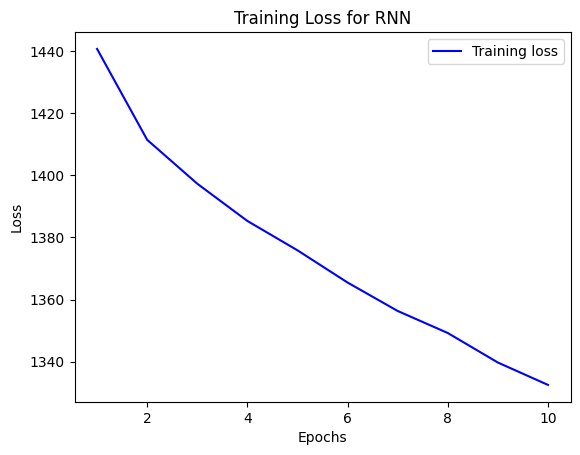

In [8]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_values):
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.title('Training Loss for RNN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Example usage:
loss_values = [1440.82, 1411.50, 1397.35, 1385.33, 1375.86, 1365.47, 1356.30, 1349.19, 1339.67, 1332.45]
plot_loss_curve(loss_values)

In [ ]:
#Single Training test -  DO NOT NEED TO RUN FOR KFOLDS
# ----------------------------------------------------------------------------
training_model = RNNClassifier(full_inputs.shape[-1], hidden_size=8 , num_classes=6).cuda()
training_model = training(full_inputs.to('cuda:0'), full_labels.to('cuda:0'), training_model, epochs=10, lr=0.001)

Epoch 1, Loss: 1909.0679713487625
Epoch 2, Loss: 1888.0568900108337
Epoch 3, Loss: 1901.854819536209
Epoch 4, Loss: 1886.8398107290268
Epoch 5, Loss: 1891.6079711914062
Epoch 6, Loss: 1882.6499382257462
Epoch 7, Loss: 1895.242572426796
Epoch 8, Loss: 1885.366261959076
Epoch 9, Loss: 1880.9891302585602
Epoch 10, Loss: 1885.5645854473114


In [ ]:
# Single training Accuracy
training_model=training_model.cpu()
model_outputs = torch.argmax(training_model(full_inputs.to('cpu').float()), axis =1)
argmax_labels = torch.argmax(torch.Tensor(full_labels), axis =1)
print(sum(model_outputs == argmax_labels)/len(model_outputs))

tensor(0.2065)


In [ ]:
# Single Validation Accuracy
model_outputs = torch.argmax(training_model(val_input.to('cpu').float()), axis =1)
argmax_labels = torch.argmax(torch.Tensor(val_labels), axis =1)
print(sum(model_outputs == argmax_labels)/len(model_outputs))

tensor(0.1924)
